# Identifying Signal and Noise Using ICA
*Written by Luke Chang*

In this tutorial we will use ICA to explore which signals in our imaging data might be real signal or artifacts.

For a brief overview of types of artifacts that might be present in your data, I recommend watching this video by Tor Wager and Martin Lindquist.

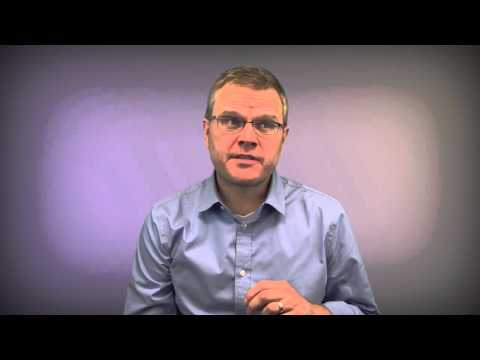

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('7Kk_RsGycHs')

## Preprocessing Data
To run this tutorial, you must have run preprocessing on at least one participant. If you are in Psych60, this has already been done for you and you can just skip to Loading Data. If you reading this online, then I recommend preprocessing your data with [fmriprep](https://fmriprep.readthedocs.io/en/stable/), which is a robust, but opinionated automated preprocessing pipeline developed by [Russ Poldrack's group at Stanford University](https://poldracklab.stanford.edu/). The developer's have made a number of choices about how to preprocess your fMRI data using best practices and have created an automated pipeline using multiple software packages that are all distributed via a [docker container](https://fmriprep.readthedocs.io/en/stable/docker.html).

In theory, this is extraodinarily straightforward to run:

 - 1. Install [Docker](https://www.docker.com/) and download image
     
     `docker pull poldracklab/fmriprep:<latest-version>`


 - 2. Run a single command in the terminal specifying the location of the data, the location of the output, the participant id, and a few specific flags depending on specific details of how you want to run the preprocessing.

    `fmriprep-docker /Users/lukechang/Dropbox/Dartbrains/Data/localizer /Users/lukechang/Dropbox/Dartbrains/Data/preproc participant --participant_label sub-S01 --write-graph --fs-no-reconall --notrack --fs-license-file ~/Dropbox/Dartbrains/License/license.txt --work-dir /Users/lukechang/Dropbox/Dartbrains/Data/work`
    
In practice, it's alway a little bit finicky to get everything set up on a particular system. Sometimes you might run into issues with a specific missing file like the [freesurfer license](https://fmriprep.readthedocs.io/en/stable/usage.html#the-freesurfer-license) even if you're not using it. You might also run into issues with the format of the data that might have some conflicts with the [bids-validator](https://github.com/bids-standard/bids-validator). In our experience, there is always some frustrations getting this to work, but it's very nice once it's done.

## Loading Data
Ok, once you've finished preprocessing some of your data with fmriprep, we can load a subject and run an ICA to explore signals that are present. Since we have completed preprocessing, our data should be realigned and also normalized to MNI stereotactic space. We will use the [nltools](https://neurolearn.readthedocs.io/en/latest/) package to work with this data in python.

In [3]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data
from nltools.plotting import component_viewer

base_dir = '../data/localizer/derivatives/preproc/fmriprep'
base_dir = '/Users/lukechang/Dropbox/Dartbrains/Data/preproc/fmriprep'
sub = 'S01'

data = Brain_Data(os.path.join(base_dir, f'sub-{sub}','func', f'sub-{sub}_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))

## More Preprocessing
Even though, we have technically already run most of the preprocessing there are a couple of more steps that will help make the ICA cleaner.

First, we will run a high pass filter to remove any low frequency scanner drift. We will pick a fairly arbitrary filter size of 0.0078hz (1/128s). We will also run spatial smoothing with a 6mm FWHM gaussian kernel to increase a signal to noise ratio at each voxel. These steps are very easy to run using nltools after the data has been loaded.

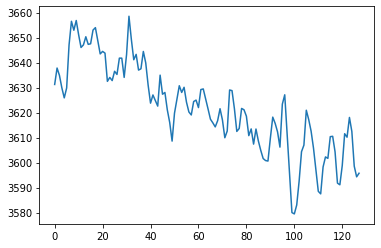

In [8]:
plt.plot(data.mean(axis=1))

In [12]:
print(1/2.4)
print(1/128)

0.4166666666666667
0.0078125


In [9]:
data = data.filter(sampling_freq=1/2.4, high_pass=1/128)

data = data.smooth(6)

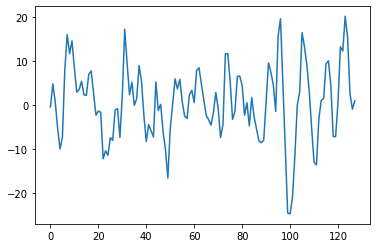

In [10]:
plt.plot(data.mean(axis=1))

threshold is ignored for simple axial plots


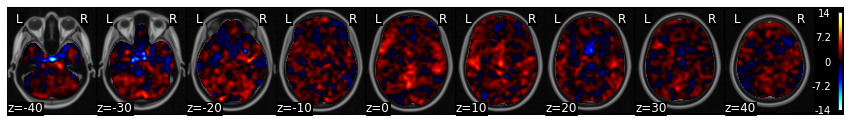

In [13]:
data.mean().plot()

## Independent Component Analysis (ICA)
Ok, we are finally ready to run an ICA analysis on our data. 

ICA attempts to perform blind source separation by decomposing a multivariate signal into additive subcomponents that are maximally independent. 

We will be using the `decompose()` method on our `Brain_Data` instance. This runs the [FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.fastica.html) algorithm implemented by scikit-learn. You can choose whether you want to run spatial ICA by setting `axis='voxels` or temporal ICA by setting `axis='images'`. We also recommend running the whitening flat `whiten=True`. By default `decompose` will estimate the maximum components that are possible given the data. We recommend using a completely arbitrary heuristic of 20-30 components.

In [14]:
tr = 2.4
output = data.decompose(algorithm='ica', n_components=30, axis='images', whiten=True)

# Viewing Components

We will use the interactive `component_viewer` from nltools to explore the results of the analysis. This viewer uses ipywidgets to select the `Component` to view and also the threshold. You can manually enter a component number to view or scroll up and down. 

Components have been standardized, this allows us to threshold the brain in terms of standard deviations. For example, the default threshold of 2.0, means that any voxel that loads on the component greater or less than 2 standard deviations will be overlaid on the standard brain. You can play with different thresholds to be more or less inclusive - a threshold of 0 will overlay all of the voxels. If you play with any of the numbers, make sure you press tab to update the plot.

The second plot is the time course of the voxels that load on the component. The x-axis is in TRs, which for this dataset is 2.4 sec.

The third plot is the powerspectrum of the timecourse. There is not a large range of possible values as we can only observe signals at the nyquist frequency, which is half of our sampling frequency of 1/2.4s (approximately 0.21hz) to a lower bound of 0.0078hz based on our high pass filter. There might be systematic oscillatory signals. Remember, that signals that oscillate a faster frequency than the nyquist frequency will be aliased. This includes physiological artifacts such as respiration and cardiac signals.

It is important to note that ICA cannot resolve the sign of the component. So make sure you consider signals that are positive as well as negative.

In [15]:
component_viewer(output, tr=2.4)

interactive(children=(BoundedIntText(value=0, description='Component', max=29), BoundedFloatText(value=2.0, de…

![](../../images/ica/ica_viewer_demo.gif)

In [29]:
# function(data)

# data.function()

# print(type([1,2,3]))
# print(type((1,2,3)))
# print(type({'a':1,'b':2}))

a = 'everyone'
f"hello: 'hi'"
# fhello: 'hi''

SyntaxError: invalid syntax (<ipython-input-29-474a57c403d1>, line 11)

# Exercises

For this tutorial, try to guess which components are signal and which are noise. Also, be sure to label the type of noise you think you might be seeing (e.g., head motion, scanner spikes, cardiac, respiration, etc.) Do this for subjects `s01` and `s02`. 

What features do you think are important to consider when making this judgment?  Does the spatial map provide any useful information? What about the timecourse of the component? Does it map on to the plausible timecourse of the task.What about the power spectrum? 
